# ✈️ Flight Delay Prediction

Predicting flight delays using passenger, airport, and scheduling data from airline records.


## 📘 Project Overview

Flight delays cost airlines millions and impact traveler experience. In this project, we use a machine learning approach to analyze flight records and predict delays based on features like:

- 🛫 Departure airport and destination  
- 👤 Passenger demographics  
- 📅 Date and time of flight  
- 🧳 Airline and airport information  

We compare the performance of Logistic Regression, XGBoost, and a Neural Network in predicting whether a flight will be **delayed or on time**.


## 📊 Dataset Summary

The dataset `Airline Dataset.csv` includes fields such as:

- `Passenger ID`, `First Name`, `Last Name`  
- `Gender`, `Age`, `Nationality`  
- `Airport Name`, `Arrival Airport`, `Country`  
- `Departure Date`, `Flight Status` (target)  
- `Pilot Name`, `Flight Status`  

Additional features were extracted, cleaned, and encoded for model training. We also used derived variables like **Day of Week** and **Month of Departure** for time-series trends.


# ✈️ Flight Delay Prediction Project

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [64]:
df = pd.read_csv("Airline_Dataset.csv")
df['Delayed'] = df['Flight Status'].apply(lambda x: 1 if x == 'Delayed' else 0)
df['Departure Date'] = pd.to_datetime(df['Departure Date'], errors='coerce')
df['Dep_Year'] = df['Departure Date'].dt.year
df['Dep_Month'] = df['Departure Date'].dt.month
df['Dep_Day'] = df['Departure Date'].dt.day
df['Dep_Weekday'] = df['Departure Date'].dt.day_name()


In [65]:
df_encoded = df.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col not in ['Flight Status', 'Pilot Name']:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le
df_encoded['Delayed'] = df['Delayed']


In [66]:
if 'Departure Date' in df_encoded.columns:
    df_encoded = df_encoded.drop(columns=['Departure Date'])
X = df_encoded.drop(columns=['Flight Status', 'Pilot Name', 'Delayed'])
y = df_encoded['Delayed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with scaling and class weight
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train_scaled, y_train)
log_preds = log_model.predict(X_test_scaled)

# XGBoost with class imbalance handling
xgb_model = XGBClassifier(eval_metric='logloss', scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, log_preds))
print("XGBoost Report:")
print(classification_report(y_test, xgb_preds))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.66      0.50      0.57     13069
           1       0.34      0.50      0.40      6655

    accuracy                           0.50     19724
   macro avg       0.50      0.50      0.49     19724
weighted avg       0.55      0.50      0.51     19724

XGBoost Report:
              precision    recall  f1-score   support

           0       0.67      0.56      0.61     13069
           1       0.34      0.45      0.39      6655

    accuracy                           0.52     19724
   macro avg       0.51      0.51      0.50     19724
weighted avg       0.56      0.52      0.54     19724



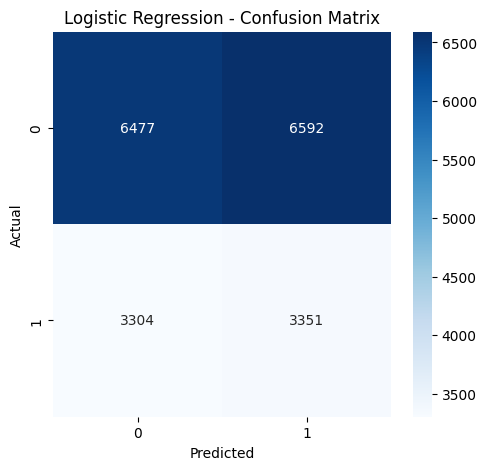

In [50]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, log_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual");

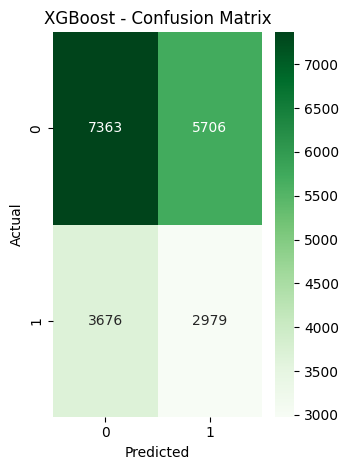

In [51]:
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Greens')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

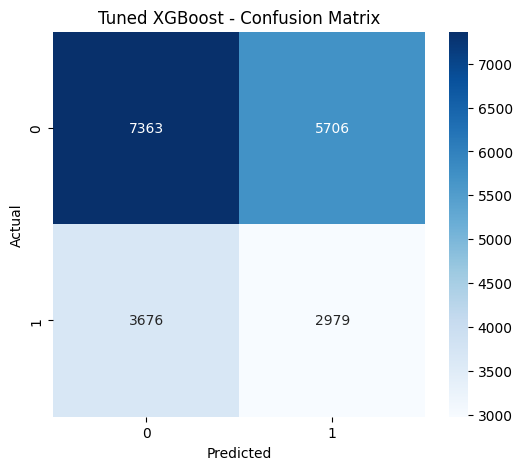

In [52]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Tuned XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [53]:
from sklearn.utils import class_weight
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Input

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Compute class weights
class_weights_dict = {0: 1.0, 1: 2.5}

model = Sequential()
model.add(Input(shape=(X_train_nn.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_nn, y_train_nn, epochs=15, batch_size=32, validation_split=0.2, verbose=1, class_weight=class_weights_dict)

loss, accuracy = model.evaluate(X_test_nn, y_test_nn, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")
y_pred_nn = (model.predict(X_test_nn) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test_nn, y_pred_nn))
print("Confusion Matrix:\n", confusion_matrix(y_test_nn, y_pred_nn))

Epoch 1/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4700 - loss: 1.1824 - val_accuracy: 0.3415 - val_loss: 0.7639
Epoch 2/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.4134 - loss: 1.0451 - val_accuracy: 0.3280 - val_loss: 0.7420
Epoch 3/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3663 - loss: 1.0331 - val_accuracy: 0.3256 - val_loss: 0.7411
Epoch 4/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.3398 - loss: 1.0303 - val_accuracy: 0.3253 - val_loss: 0.7394
Epoch 5/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3365 - loss: 1.0310 - val_accuracy: 0.3253 - val_loss: 0.7414
Epoch 6/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3343 - loss: 1.0298 - val_accuracy: 0.3254 - val_loss: 0.7393
Epoch 7/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3343 - loss: 1.0310 - val_accuracy: 0.3253 - val_loss: 0.7393
Epoch 8/15
1973/1973 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3336 - loss: 1.0302 

<Axes: title={'center': 'Top 10 Airlines by Delay Rate'}, xlabel='Airport Name'>

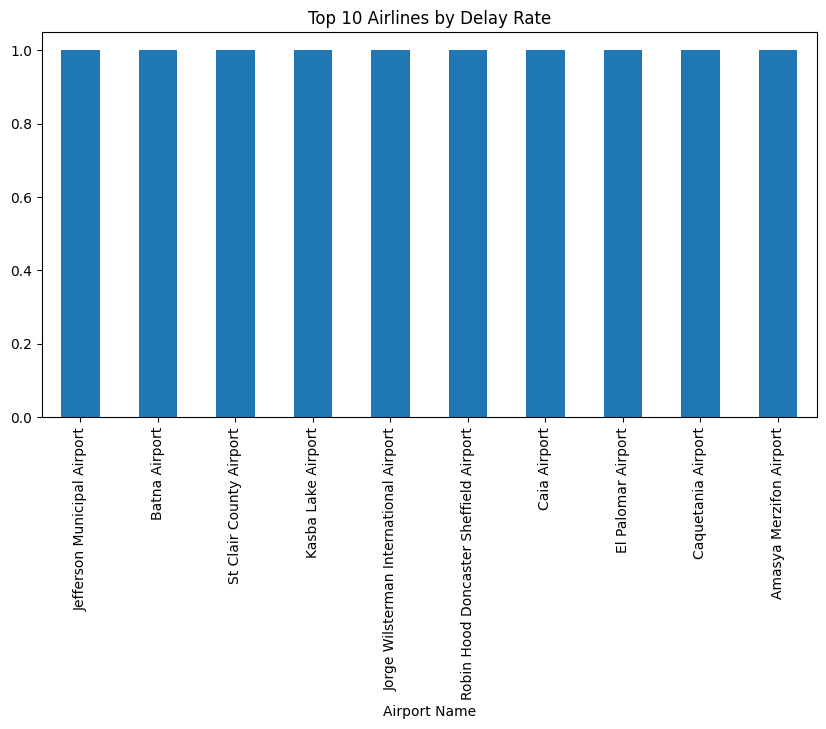

In [54]:
delay_rate_by_airline = df.groupby("Airport Name")["Delayed"].mean().sort_values(ascending=False).head(10)
delay_rate_by_airline.plot(kind='bar', figsize=(10, 5), title="Top 10 Airlines by Delay Rate")

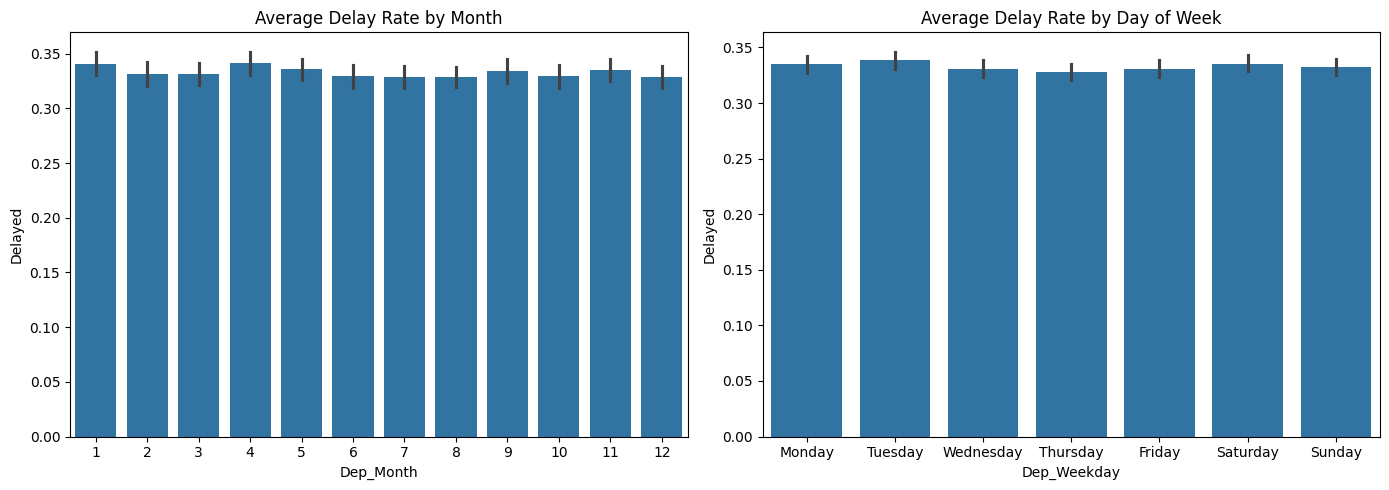

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Monthly
sns.barplot(data=df, x='Dep_Month', y='Delayed', ax=axs[0])
axs[0].set_title("Average Delay Rate by Month")

# Weekday
sns.barplot(data=df, x='Dep_Weekday', y='Delayed', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ax=axs[1])
axs[1].set_title("Average Delay Rate by Day of Week")

plt.tight_layout()
plt.show()

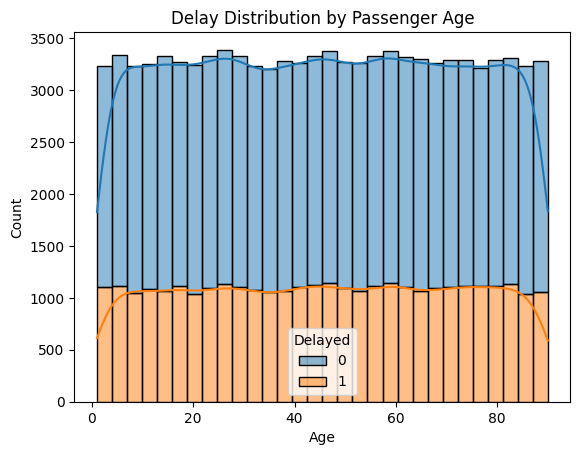

In [56]:
sns.histplot(data=df, x='Age', hue='Delayed', bins=30, kde=True, multiple='stack')
plt.title("Delay Distribution by Passenger Age")
plt.show()

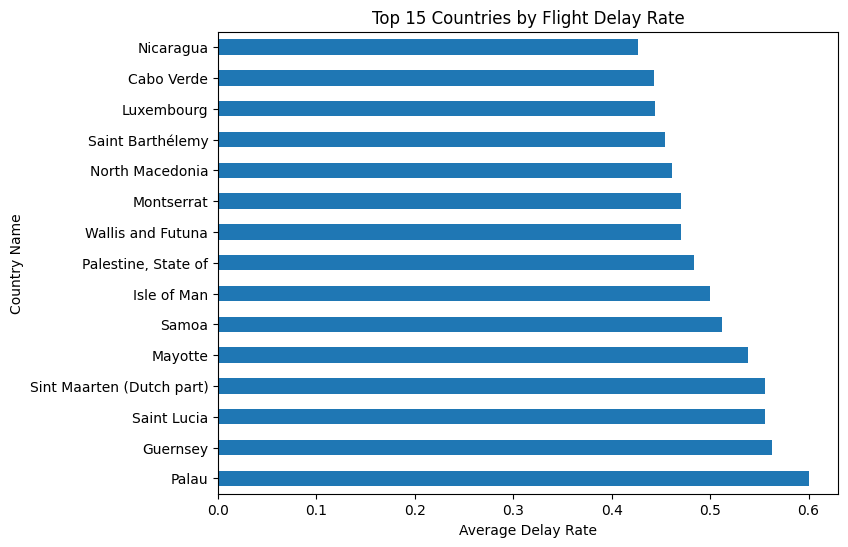

In [57]:
country_delay = df.groupby("Country Name")["Delayed"].mean().sort_values(ascending=False).head(15)
country_delay.plot(kind='barh', title="Top 15 Countries by Flight Delay Rate", figsize=(8,6))
plt.xlabel("Average Delay Rate")
plt.show()

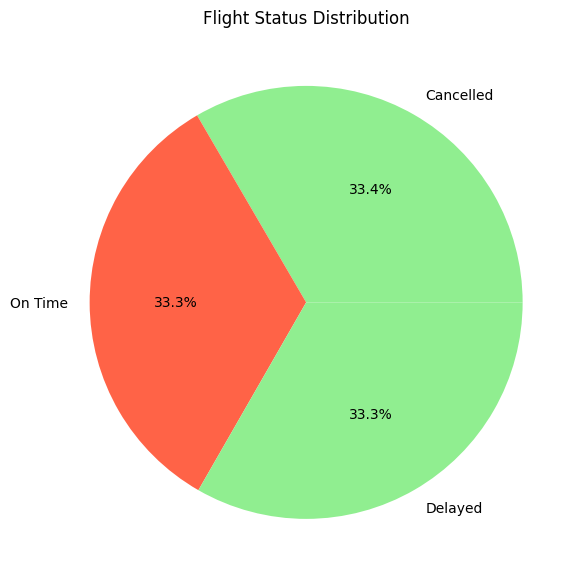

In [58]:
plt.figure(figsize=(6, 6))
df['Flight Status'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen', 'tomato'])
plt.title('Flight Status Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()

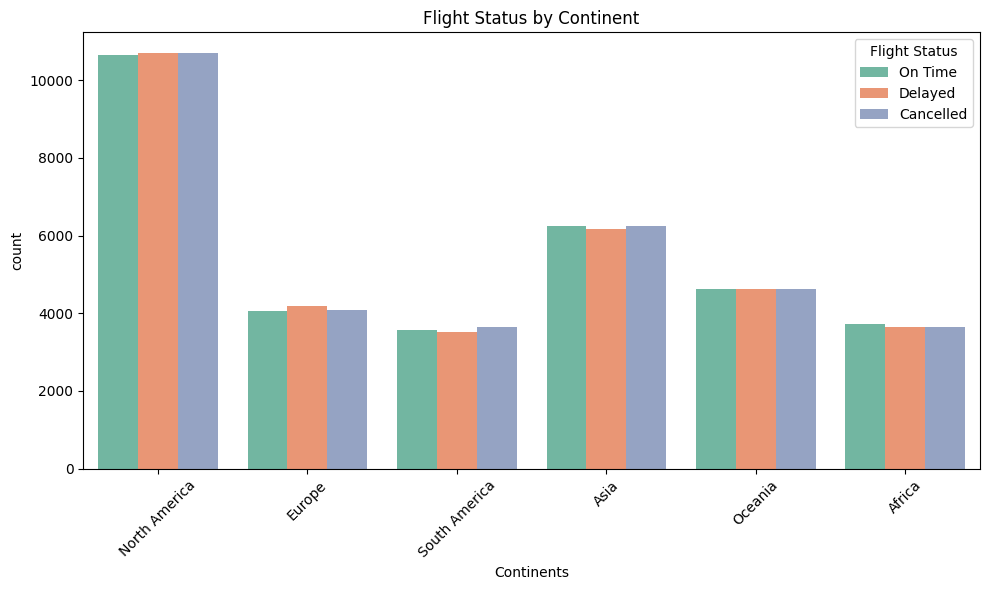

In [59]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Continents', hue='Flight Status', palette='Set2')
plt.title('Flight Status by Continent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

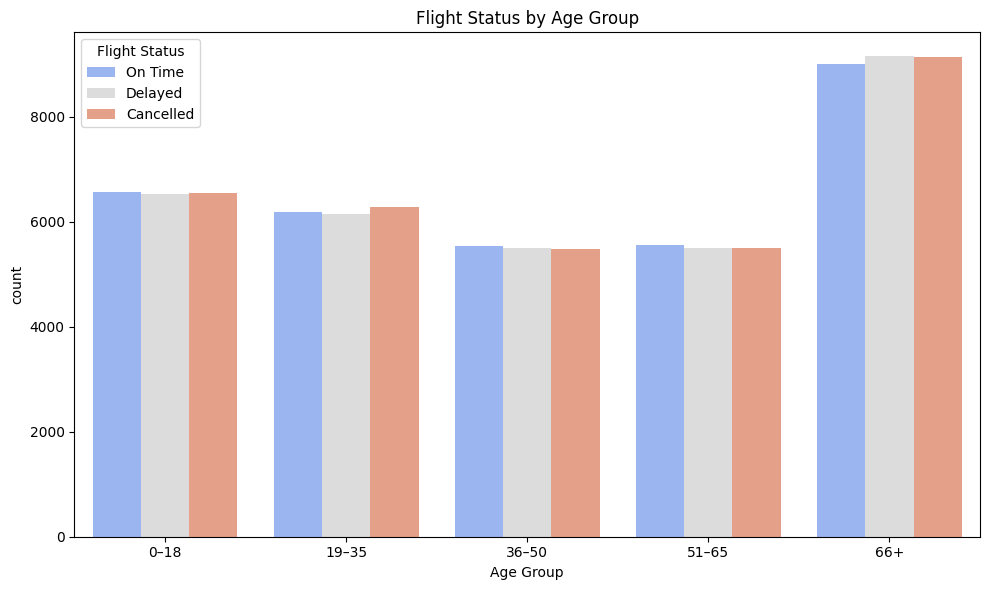

In [60]:
bins = [0, 18, 35, 50, 65, 100]
labels = ['0–18', '19–35', '36–50', '51–65', '66+']
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Age Group', hue='Flight Status', palette='coolwarm')
plt.title('Flight Status by Age Group')
plt.tight_layout()
plt.show()

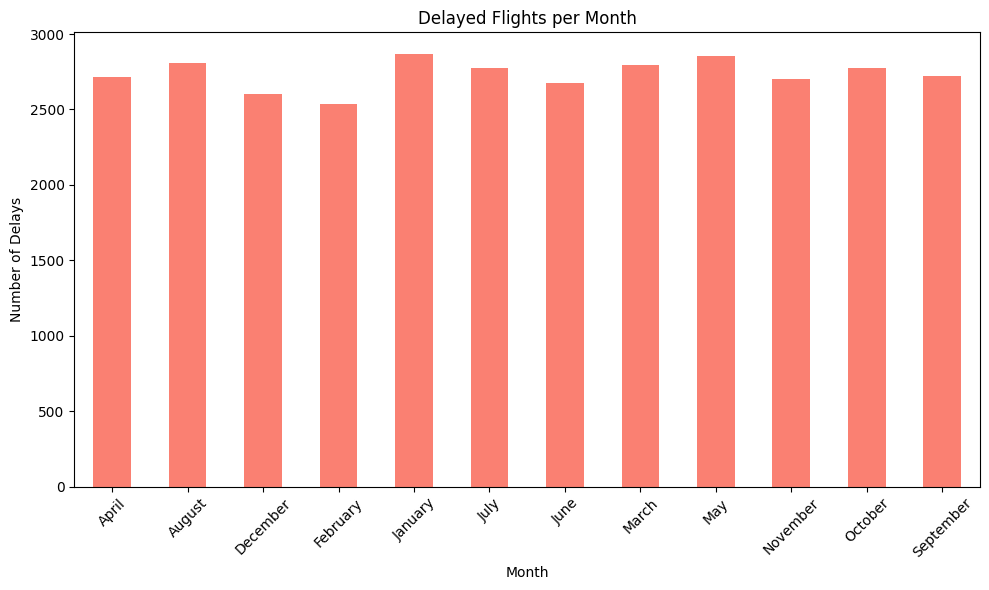

In [61]:
df['Departure Date'] = pd.to_datetime(df['Departure Date'], errors='coerce')
df['Month'] = df['Departure Date'].dt.month_name()

monthly_delay = df[df['Flight Status'] == 'Delayed']['Month'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
monthly_delay.plot(kind='bar', color='salmon')
plt.title('Delayed Flights per Month')
plt.xlabel('Month')
plt.ylabel('Number of Delays')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

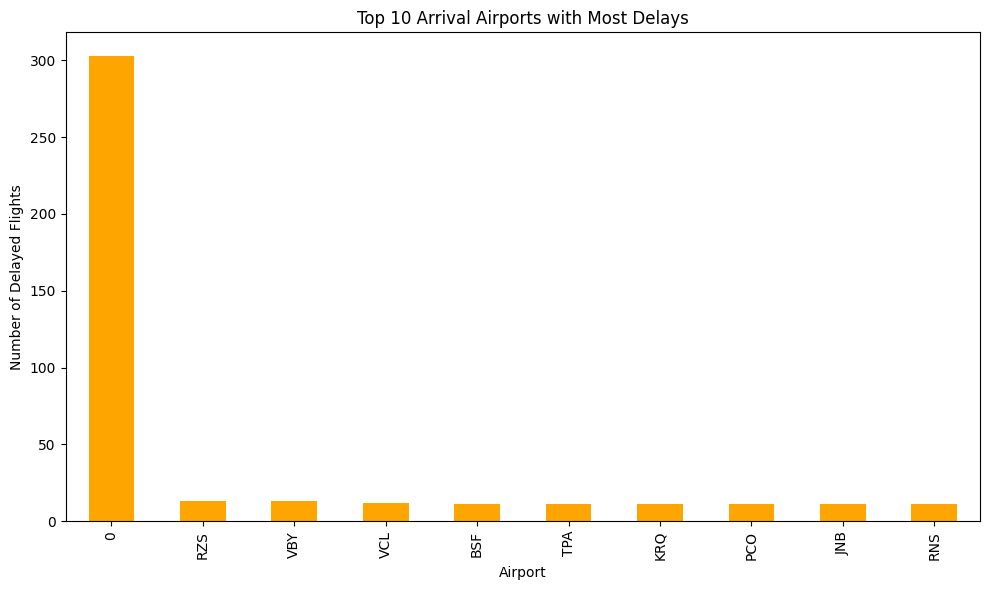

In [62]:
top_airports = df[df['Flight Status'] == 'Delayed']['Arrival Airport'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_airports.plot(kind='bar', color='orange')
plt.title('Top 10 Arrival Airports with Most Delays')
plt.xlabel('Airport')
plt.ylabel('Number of Delayed Flights')
plt.tight_layout()
plt.show()